# 3D map simulation

## Prerequisites

- Knowledge of 3D extraction and datasets used in gammapy, see for instance the [first analysis tutorial](../../starting/analysis_1.ipynb)

## Context

To simulate a specific observation, it is not always necessary to simulate the full photon list. For many uses cases, simulating directly a reduced binned dataset is enough: the IRFs reduced in the correct geometry are combined with a source model to predict an actual number of counts per bin. The latter is then used to simulate a reduced dataset using Poisson probability distribution.

This can be done to check the feasibility of a measurement (performance / sensitivity study), to test whether fitted parameters really provide a good fit to the data etc.

Here we will see how to perform a 3D simulation of a CTA observation, assuming both the spectral and spatial morphology of an observed source.

**Objective: simulate a 3D observation of a source with CTA using the CTA 1DC response and fit it with the assumed source model.**

## Proposed approach:

Here we can't use the regular observation objects that are connected to a `DataStore`. Instead we will create a fake `~gammapy.data.Observation` that contain some pointing information and the CTA 1DC IRFs (that are loaded with `~gammapy.irf.load_cta_irfs`).

Then we will create a `~gammapy.datasets.MapDataset` geometry and create it with the `~gammapy.makers.MapDatasetMaker`.

Then we will be able to define a model consisting of  a `~gammapy.modeling.models.PowerLawSpectralModel` and a `~gammapy.modeling.models.GaussianSpatialModel`. We will assign it to the dataset and fake the count data.


## Imports and versions

In [1]:
%matplotlib inline
import gammapy
gammapy.__version__

'0.19'

In [2]:
import numpy as np
import astropy.units as u
import scipy
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    GaussianSpatialModel,
    SkyModel,
    Models,
    FoVBackgroundModel,
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.data import Observation, DataStore
from gammapy.datasets import MapDataset
from regions import CircleSkyRegion
from gammapy.estimators import ExcessMapEstimator, FluxPointsEstimator

## Simulation

We will simulate using the CTA-1DC IRFs shipped with gammapy. Note that for dedictaed CTA simulations, you can simply use [`Observation.from_caldb()`]() without having to externally load the IRFs

In [3]:
# Loading IRFs - one typical HESS IRF 
datastore = DataStore.from_dir('/Users/asinha/HAP-fr/ash_stereo_Prod17_Calib0834_thsq64/')
obs = datastore.obs(23523)
irfs = {'aeff': obs.aeff,
         'psf': obs.psf,
        'edisp': obs.edisp,
        'bkg': obs.bkg
       }

No HDU found matching: OBS_ID = 23523, HDU_TYPE = rad_max, HDU_CLASS = None
Missing 'HDUCLAS2' keyword assuming 'BKG'


In [4]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 200 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [5]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_energy_bounds(energy_min=800*u.GeV, 
                                         energy_max=20*u.TeV,
                                        nbin=5, per_decade=True, name='energy')
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(6, 7),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_energy_bounds(energy_min=100*u.GeV, 
                                         energy_max=100*u.TeV,
                                        nbin=5, per_decade=True, name='energy_true')
empty = MapDataset.create(geom, name="dataset-simu", energy_axis_true=energy_true)

In [6]:
from gammapy.modeling.models import SpatialModel, Parameter, DiskSpatialModel, compute_sigma_eff
from astropy.coordinates.angle_utilities import angular_separation


class MyCustomDiskModel(SpatialModel):
    """My custom Energy Dependent Disk model.

    Parameters
    ----------
    lon_0, lat_0 : `~astropy.coordinates.Angle`
        Center position
    r_0 : `~astropy.coordinates.Angle`
        :math:`a`: length of the major semiaxis at 1 TeV, in angular units.
    e : `float`
        Eccentricity of the ellipse (:math:`0< e< 1`).
    phi : `~astropy.coordinates.Angle`
        Rotation angle :math:`\phi`: of the major semiaxis.
        Increases counter-clockwise from the North direction.
    edge_width : float
        Width of the edge. The width is defined as the range within which
        the smooth edge of the model drops from 95% to 5% of its amplitude.
        It is given as fraction of r_0.
    frame : {"icrs", "galactic"}
        Center position coordinate frame
    """

    tag = "MyCustomDiskModel"
    is_energy_dependent = True
    lon_0 = Parameter("lon_0", "0 deg")
    lat_0 = Parameter("lat_0", "0 deg", min=-90, max=90)
    r_1TeV = Parameter("r_1TeV", "1 deg", min=0)
    alpha = Parameter("alpha", 0.1, min=0.0, max=2.0)
    e = Parameter("e", 0, min=0, max=1, frozen=True)
    phi = Parameter("phi", "0 deg", frozen=True)
    edge_width = Parameter("edge_width", value=0.01, min=0, max=1, frozen=True)

    @property
    def evaluation_bin_size_min(self):
        return 0.01*u.deg
    
    @property
    def evaluation_radius(self):
        return 2.0*self.r_1TeV.quantity

    @staticmethod
    def get_r0(energy, r_1TeV, alpha):
        return r_1TeV * np.power(energy/(1.0*u.TeV),-alpha)
    
    def evaluate_norm_at_energy(r_0, e):
        semi_minor = r_0 * np.sqrt(1 - e ** 2)

        def integral_fcn(x, a, b):
            A = 1 / np.sin(a) ** 2
            B = 1 / np.sin(b) ** 2
            C = A - B
            cs2 = np.cos(x) ** 2

            return 1 - np.sqrt(1 - 1 / (B + C * cs2))
        
        norms = []
        for r in r_0:
            norms.append((
            2
            * scipy.integrate.quad(
                lambda x: integral_fcn(x, r_0, semi_minor), 0, np.pi
            )[0]
        ) ** -1)
            
        print(norms)
        return norms


    @staticmethod
    def evaluate(lon, lat, energy, lon_0,  lat_0, r_1TeV, alpha, e, phi, edge_width): 
        r_0 = MyCustomDiskModel.get_r0(energy, r_1TeV, alpha)
        #r_0 = r_1TeV
        print(r_0)
        
        sep = angular_separation(lon, lat, lon_0, lat_0)
        print(sep.shape)
        norm = 1.0/(2.0*np.pi*(1-np.cos(r_0)))
        
        
        for i,ene in enumerate(energy):
            value = sep
            mask = value <= r_0
            value[mask] = r_0[i]
            value[~mask] = 0
            
            
        
        
        return u.Quantity(value, "sr-1", copy=False)
        
        

        """
        if e == 0:
            sigma_eff = r_0
        else:
            sigma_eff = compute_sigma_eff(lon_0, lat_0, lon, lat, phi, r_0, e)[1]
        print(sigma_eff)
                
        norms = MyCustomDiskModel.evaluate_norm_at_energy(r_0, e)

        in_ellipse = DiskSpatialModel._evaluate_smooth_edge(
            sep - sigma_eff, sigma_eff * edge_width
        )
        return u.Quantity(norms * in_ellipse, "sr-1", copy=False)
        """

        

In [7]:
from gammapy.modeling.models import SpatialModel
from astropy.coordinates.angle_utilities import angular_separation


class MyCustomGaussianModel(SpatialModel):
    """My custom Energy Dependent Gaussian model.

    Parameters
    ----------
    lon_0, lat_0 : `~astropy.coordinates.Angle`
        Center position
    sigma_1TeV : `~astropy.coordinates.Angle`
        Width of the Gaussian at 1 TeV
    sigma_10TeV : `~astropy.coordinates.Angle`
        Width of the Gaussian at 10 TeV

    """

    tag = "MyCustomGaussianModel"
    is_energy_dependent = True
    lon_0 = Parameter("lon_0", "0 deg")
    lat_0 = Parameter("lat_0", "0 deg", min=-90, max=90)

    sigma_1TeV = Parameter("sigma_1TeV", "2.0 deg", min=0)
    sigma_10TeV = Parameter("sigma_10TeV", "0.2 deg", min=0)

    @staticmethod
    def evaluate(lon, lat, energy, lon_0, lat_0, sigma_1TeV, sigma_10TeV):
        
        print(energy.shape, lon.shape, lat.shape)

        sep = angular_separation(lon, lat, lon_0, lat_0)

        # Compute sigma for the given energy using linear interpolation in log energy
        sigma_nodes = u.Quantity([sigma_1TeV, sigma_10TeV])
        energy_nodes = [1, 10] * u.TeV
        log_s = np.log(sigma_nodes.to("deg").value)
        log_en = np.log(energy_nodes.to("TeV").value)
        log_e = np.log(energy.to("TeV").value)
        sigma = np.exp(np.interp(log_e, log_en, log_s)) * u.deg

        exponent = -0.5 * (sep / sigma) ** 2
        norm = 1 / (2 * np.pi * sigma ** 2)
        print(norm.shape, exponent.shape)
        val = norm * np.exp(exponent)
        print(val.shape)
        return norm * np.exp(exponent)

In [8]:
# Define sky model to used simulate the data.

spatial_model1 = MyCustomDiskModel(
    lon_0="0.0 deg", lat_0="0.0 deg", frame="galactic"
)

spatial_model2 = MyCustomGaussianModel(
    lon_0="0.0 deg", lat_0="0.0 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=2, amplitude="4e-12 cm-2 s-1 TeV-1", reference="1 TeV"
)
model_simu1 = SkyModel(
    spatial_model=spatial_model1,
    spectral_model=spectral_model,
    name="model-simu",
)

model_simu2 = SkyModel(
    spatial_model=spatial_model2,
    spectral_model=spectral_model,
    name="model-simu",
)

bkg_model = FoVBackgroundModel(dataset_name="dataset-simu")

models = Models([model_simu1, bkg_model])
print(models)

[[[1.]]] deg
(1, 2, 2)


TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

In [ ]:
%debug

> /opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py(1067)__setitem__()
   1065         if not self.isscalar and 'info' in self.__dict__:
   1066             self.info.adjust_indices(i, value, len(self))
-> 1067         self.view(np.ndarray).__setitem__(i, self._to_own_unit(value))
   1068 
   1069     # __contains__ is OK

ipdb> u
> /var/folders/vt/5svqpq1n5n38p34hdvk8q14h0000gp/T/ipykernel_52123/3077345116.py(87)evaluate()
     85             value = sep
     86             mask = value <= r_0
---> 87             value[mask] = r_0[i]
     88             value[~mask] = 0
     89 

ipdb> mask
array([[[ True,  True],
        [ True,  True]]])
ipdb> value
<Quantity [[[0.00617066, 0.00617066],
            [0.00617066, 0.00617066]]] rad>
ipdb> mask.shape
(1, 2, 2)
ipdb> value.shape
(1, 2, 2)
ipdb> r_0
<Quantity [[[1.]]] deg>
ipdb> i
0
ipdb> r_0[i]
<Quantity [[1.]] deg>


In [ ]:
spatial_model.get_r0([1.0, 5, 10]*u.TeV, 1.0*u.deg, 0.1)

In [ ]:
models.parameters.to_table()

Now, comes the main part of dataset simulation. We create an in-memory observation and an empty dataset. We then predict the number of counts for the given model, and Poission fluctuate it using `fake()` to make a simulated counts maps. Keep in mind that it is important to specify the `selection` of the maps that you want to produce 

In [ ]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

In [ ]:
# Make the MapDataset
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])

maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=2.3 * u.deg)

dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)

In [ ]:
# Add the model on the dataset and Poission fluctuate
dataset.models = models
dataset.fake()

In [ ]:
dataset._geom

In [ ]:
print(dataset)

In [ ]:
spectral_model.plot(energy_bounds=[0.3,10]*u.TeV, energy_power=2)

The datset has been simultaed. Now look at the excess maps.

In [ ]:
dataset.models = None

In [ ]:
estimator = ExcessMapEstimator(correlation_radius=0.5*u.deg)
res1 = estimator.run(dataset)
res1['sqrt_ts'].plot(add_cbar=True, cmap='coolwarm')

In [ ]:
estimator = ExcessMapEstimator(correlation_radius=0.5*u.deg, energy_edges=[0.5, 1, 5, 20]*u.TeV)
res1 = estimator.run(dataset)
res1['sqrt_ts'].plot_grid(add_cbar=True, cmap='coolwarm')

In [ ]:
dataset1 = dataset.copy(name='dataset1')
dataset2 = dataset.copy(name='dataset2')

## Fit


### 3D fit

In [147]:
bkg1 = FoVBackgroundModel(dataset_name=dataset1.name)
models1 = Models([bkg1])
dataset1.models = models1

In [148]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset1])

CPU times: user 248 ms, sys: 46.4 ms, total: 294 ms
Wall time: 295 ms


In [149]:
TS0 = dataset1.stat_sum()

In [150]:
result.parameters.to_table()

type,name,value,unit,error,min,max,frozen,link
str8,str9,float64,str3,float64,float64,float64,bool,str1
spectral,norm,1.0206e+00,,1.310e-03,nan,nan,False,
spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,


In [151]:
spatial1 = GaussianSpatialModel(frame='galactic')
spectral1 = PowerLawSpectralModel()
sky_model1 = SkyModel(spatial_model=spatial1, 
                      spectral_model=spectral1, name='sky1')

models1.append(sky_model1)
dataset1.models = models1 

In [166]:
spatial1.parameters['lon_0'].value = 0.0
spatial1.parameters['lat_0'].value = 0.0
spatial1.parameters['sigma'].value = 0.2

In [167]:
dataset1.models.names

['dataset1-bkg', 'sky1']

In [168]:
%%time
fit = Fit(optimize_opts={"print_level": 1})
result = fit.run(datasets=[dataset1])

CPU times: user 49.8 s, sys: 9.52 s, total: 59.3 s
Wall time: 59.6 s


In [169]:
TS1 = dataset1.stat_sum()
print('detection TS: ',(TS0-TS1))

detection TS:  530.4259161062073


/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  return super().imshow(X, *args, origin=origin, **kwargs)


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

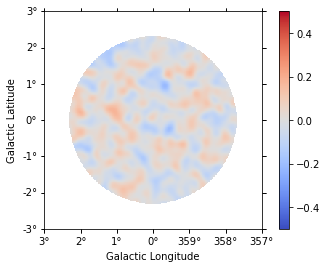

In [170]:
dataset1.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)

In [171]:
models1.to_parameters_table()

model,type,name,value,unit,error,min,max,frozen,link
str12,str8,str9,float64,str14,float64,float64,float64,bool,str1
dataset1-bkg,spectral,norm,1.0058e+00,,1.892e-03,nan,nan,False,
dataset1-bkg,spectral,tilt,0.0000e+00,,0.000e+00,nan,nan,True,
dataset1-bkg,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
sky1,spectral,index,1.5768e+00,,5.832e-02,nan,nan,False,
sky1,spectral,amplitude,1.7612e-12,cm-2 s-1 TeV-1,2.664e-13,nan,nan,False,
sky1,spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,
sky1,spatial,lon_0,-9.2080e-02,deg,3.600e-02,nan,nan,False,
sky1,spatial,lat_0,7.0304e-03,deg,3.354e-02,-9.000e+01,9.000e+01,False,
sky1,spatial,sigma,5.7940e-01,deg,2.916e-02,0.000e+00,nan,False,


<WCSAxesSubplot:xlabel='Galactic Longitude', ylabel='Galactic Latitude'>

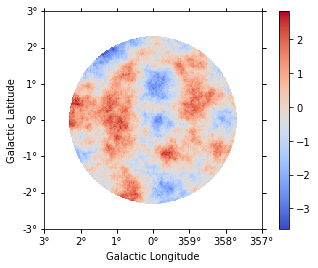

In [172]:
estimator = ExcessMapEstimator(correlation_radius=0.5*u.deg)
res1 = estimator.run(dataset1)
res1['sqrt_ts'].plot(add_cbar=True, cmap='coolwarm')

array([<WCSAxesSubplot:title={'center':'Energy 0.8 TeV - 1.0 TeV '}, xlabel='Galactic Longitude', ylabel='Galactic Latitude'>,
       <WCSAxesSubplot:title={'center':'Energy 1.0 TeV - 5.0 TeV '}, xlabel='Galactic Longitude'>,
       <WCSAxesSubplot:title={'center':'Energy 5.0 TeV - 20.0 TeV '}, xlabel='Galactic Longitude'>],
      dtype=object)

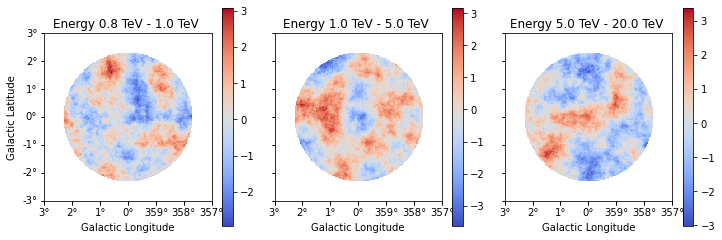

In [173]:
estimator = ExcessMapEstimator(correlation_radius=0.5*u.deg, energy_edges=[0.5, 1, 5, 20]*u.TeV)
res1 = estimator.run(dataset1)
res1['sqrt_ts'].plot_grid(add_cbar=True, cmap='coolwarm')

<AxesSubplot:xlabel='Energy [TeV]', ylabel='e2 * dnde [TeV / (cm2 s)]'>

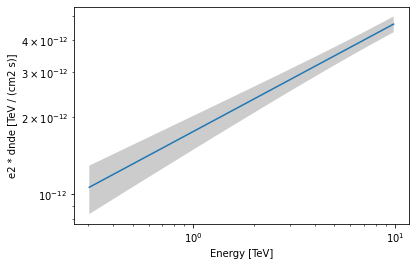

In [190]:
sky_model1.spectral_model.plot(energy_bounds=[0.3,10]*u.TeV, energy_power=2)
sky_model1.spectral_model.plot_error(energy_bounds=[0.3,10]*u.TeV, energy_power=2)

## Fit spectrum in an on-region
- Does this mimic the reflected ?

In [160]:
def fit_different_on(radius=[]):
    results = []
    for r in radius:
        on_region = CircleSkyRegion(center=SkyCoord(0,0, unit='deg', frame='galactic'),
                           radius=r)
        dataset_spectrum = dataset2.to_spectrum_dataset(on_region=on_region)
        spectral2 = PowerLawSpectralModel()
        sky_model2 = SkyModel(spectral_model=spectral2)
        dataset_spectrum.models = sky_model2
        fit = Fit(optimize_opts={"print_level": 0})
        result = fit.run(datasets=[dataset_spectrum])
        results.append(result)
    return results

In [161]:
radius = np.linspace(0.5, 5, 10)
radius = radius*u.deg
print(radius)

[0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ] deg


In [162]:
%%time
results = fit_different_on(radius)

/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: invalid value encountered in multiply
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/anaconda3/envs/gammapy-0.19/lib/python3.9/site-packages/astropy/units/quantity.py:486: RuntimeWarning: divide by ze

CPU times: user 5.55 s, sys: 613 ms, total: 6.16 s
Wall time: 6.15 s


In [163]:
index = []
index_err =[]
amplitude = []
amplitude_err = []
for aresult in results:
    index.append(aresult.parameters['index'].value)
    index_err.append(aresult.parameters['index'].error)
    amplitude.append(aresult.parameters['amplitude'].value)
    amplitude_err.append(aresult.parameters['amplitude'].error)

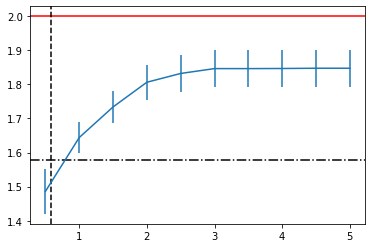

In [164]:
plt.errorbar(x=radius.value, y=index, yerr=index_err)
plt.axhline(model_simu.parameters['index'].value, color='red')
plt.axhline(spectral1.parameters['index'].value, color='black',ls='-.')
plt.axvline(spatial1.parameters['sigma'].value, color='black', ls='--')

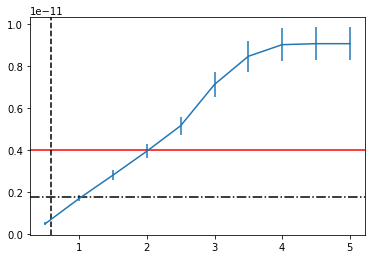

In [165]:
plt.errorbar(x=radius.value, y=amplitude, yerr=amplitude_err)
plt.axhline(model_simu.parameters['amplitude'].value, color='red')
plt.axhline(spectral1.parameters['amplitude'].value, color='black', ls='-.')
plt.axvline(spatial1.parameters['sigma'].value, color='black', ls='--')

In [5]:
a1 = (2,3)
a1

(2, 3)

In [13]:
a = np.ones((4,3))*2
a

array([[2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.],
       [2., 2., 2.]])

In [15]:
a1 = np.ones((15,4,3))

In [17]:
np.shape(a1*a)

(15, 4, 3)

In [13]:
a[2:3] = 6
a[1][1] = 4

In [14]:
a

array([[1., 1., 1., 1.],
       [1., 4., 1., 1.],
       [6., 6., 6., 6.]])

In [15]:
mask = a>3

In [16]:
mask

array([[False, False, False, False],
       [False,  True, False, False],
       [ True,  True,  True,  True]])

In [17]:
a[mask] = 3 *u.deg

In [ ]:
a.shape

In [ ]:
a.resize?

In [75]:
dataset._geom

WcsGeom

	axes       : ['lon', 'lat', 'energy']
	shape      : (300, 350, 7)
	ndim       : 3
	frame      : galactic
	projection : CAR
	center     : 0.0 deg, 0.0 deg
	width      : 6.0 deg x 7.0 deg
	wcs ref    : 0.0 deg, 0.0 deg

In [76]:
dataset.exposure.data.shape

(15, 350, 300)

In [79]:
e1 = [1,2,3]
e2 = [5,6]
e3 = [4,5,7,9]

In [83]:
np.zeros((len(e1),len(e2),len(e3)))

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [82]:
len(e1),len(e2),len(e3)

(3, 2, 4)

In [102]:
dataset.reset_data_cache()

In [103]:
dataset.edisp

KeyError: '_edisp_hdu'